# Watershed Delineation - Step-by-Step Example

This notebook demonstrates the functional approach to watershed delineation.
Each step can be run independently for easy debugging and verification.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import networkx as nx

import graph_delineator.delineate as gd

In [11]:
# Define MERIT data directories
merit_dirs = {
    "catchment": Path("/nas/cee-ice/data/MERIT-BASINS/pfaf_level_02/"),
    "river": Path("/nas/cee-ice/data/MERIT-BASINS/pfaf_level_02/"),
    "flow_dir": Path("/nas/cee-ice/data/MERIT-Hydro/processed/dir/"),
    "accum": Path("/nas/cee-ice/data/MERIT-Hydro/processed/upg/"),
    "megabasins": Path(
        "/nas/cee-ice/data/MERIT-Hydro/basins_level2/merit_hydro_vect_level2.shp"
    ),
}

# Load gauges
gauges_csv = Path("/nas/cee-water/cjgleason/ted/graph_delineator/inputs/test.csv")

In [3]:
all_gauges = gd.load_gauges(gauges_csv)
all_gauges

,id,lng,lat,name,outlet_id,geometry
0,USGS-01052500,-71.057500,44.877500,"Diamond River near Wentworth Location, NH",USGS-01059000,POINT (-71.0575 44.8775)
1,USGS-01053500,-71.128611,44.782500,"Androscoggin River at Errol, NH",USGS-01059000,POINT (-71.12861 44.7825)
2,USGS-01053600,-71.181389,44.666111,Androscoggin River below Bog Brook at Cambridg...,USGS-01059000,POINT (-71.18139 44.66611)
3,USGS-01054000,-71.190278,44.435833,"Androscoggin River near Gorham, NH",USGS-01059000,POINT (-71.19028 44.43583)
4,USGS-01054114,-71.170656,44.381319,"Peabody River at Gorham, New Hampshire",USGS-01059000,POINT (-71.17066 44.38132)
5,USGS-01054200,-70.979722,44.390556,"Wild River at Gilead, Maine",USGS-01059000,POINT (-70.97972 44.39056)
6,USGS-01054300,-70.733056,44.593333,"Ellis River at South Andover, Maine",USGS-01059000,POINT (-70.73306 44.59333)
7,USGS-01054500,-70.544167,44.551944,"Androscoggin River at Rumford, Maine",USGS-01059000,POINT (-70.54417 44.55194)
8,USGS-01055000,-70.588889,44.642778,"Swift River near Roxbury, Maine",USGS-01059000,POINT (-70.58889 44.64278)
9,USGS-01055500,-70.229722,44.269444,"Nezinscot River at Turner Center, Maine",USGS-01059000,POINT (-70.22972 44.26944)


In [4]:
megabasins_outlets = gd.get_megabasin_outlet_dict(all_gauges, merit_dirs["megabasins"])
megabasins_outlets

Identifying basins for gauges...


{73: {'USGS-01059000': ['USGS-01052500',
   'USGS-01053500',
   'USGS-01053600',
   'USGS-01054000',
   'USGS-01054114',
   'USGS-01054200',
   'USGS-01054300',
   'USGS-01054500',
   'USGS-01055000',
   'USGS-01055500',
   'USGS-01057000',
   'USGS-01059000']}}

In [5]:
def get_watershed_comids(
    gauges: gpd.GeoDataFrame, catchments: gpd.GeoDataFrame, rivers: gpd.GeoDataFrame
) -> set:
    """
    Find all COMIDs in the watershed network containing these gauges.

    Uses network traversal to find all upstream catchments from the outlet.
    """
    joined = gpd.sjoin(gauges, catchments.reset_index(), how="left", predicate="within")
    gauge_comids = set(joined["COMID"].dropna().unique())

    if not gauge_comids:
        return set()

    # Build network graph
    G = nx.DiGraph()
    for comid in rivers.index:
        nextdown = rivers.loc[comid, "NextDownID"]
        if nextdown != "0" and nextdown in rivers.index:
            G.add_edge(comid, nextdown)

    # Find all upstream catchments
    network_comids = set()
    for start_comid in gauge_comids:
        if start_comid in G:
            # Add all ancestors (upstream)
            ancestors = {int(a) for a in nx.ancestors(G, start_comid)}
            network_comids.update(ancestors)

            # Add all descendants (downstream)
            descendants = {int(d) for d in nx.descendants(G, start_comid)}
            network_comids.update(descendants)

            # Add the node itself
            network_comids.add(int(start_comid))

    return network_comids

In [93]:
for megabasin_id, outlet_dict in megabasins_outlets.items():
    print(f"\n{'=' * 60}")
    print(f"Processing Basin {megabasin_id}")
    print(f"{'=' * 60}")

    # Load basin data
    mega_catchments, mega_rivers = gd.load_basin_data(megabasin_id, merit_dirs)

    # Process each outlet in this basin
    for outlet_id, outlet_gauge_ids in outlet_dict.items():
        print(f"\nProcessing outlet {outlet_id} ({len(outlet_gauge_ids)} gauges)")

        gauges = all_gauges[all_gauges["id"].isin(outlet_gauge_ids)]

        comids = get_watershed_comids(gauges, mega_catchments, mega_rivers)

        catchments = mega_catchments.loc[mega_catchments.index.isin(comids)]
        rivers = mega_rivers.loc[mega_rivers.index.isin(comids)]

        # Build graph with all geometries
        G = gd.build_graph_with_geometries(catchments, rivers)

        break
    break


Processing Basin 73
  Loading data from pfaf_73_MERIT_Hydro_v07_Basins_v01
    Loaded 23290 catchments, 23290 rivers

Processing outlet USGS-01059000 (12 gauges)


/tmp/ipykernel_1155260/457192883.py:11: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  joined = gpd.sjoin(gauges, catchments.reset_index(), how='left', predicate='within')


Built graph with 201 nodes, 200 edges


In [100]:
rivers

,lengthkm,lengthdir,sinuosity,slope,uparea,order,strmDrop_t,slope_taud,NextDownID,maxup,up1,up2,up3,up4,geometry
COMID,,,,,,,,,,,,,,,
73000548,4.003596,3.407992,1.174767,0.000050,389.436984,3,0.2,0.000050,73000947,2,73000555,73000602,0,0,"LINESTRING (-70.99833 45.06083, -70.9975 45.06..."
73000555,9.358833,7.043559,1.328708,0.003855,305.294288,2,36.1,0.003855,73000548,2,73000568,73000673,0,0,"LINESTRING (-70.985 45.09, -70.98417 45.09083,..."
73000568,7.703432,5.377993,1.432399,0.000649,222.325940,2,5.0,0.000649,73000555,2,73000597,73000700,0,0,"LINESTRING (-70.98333 45.15333, -70.98417 45.1..."
73000589,0.453934,0.320970,1.414256,0.002422,73.316279,2,1.1,0.002422,73000960,2,73000617,73000626,0,0,"LINESTRING (-71.15 45.005, -71.14917 45.00583,..."
73000595,2.975279,2.530221,1.175897,0.000034,113.076821,2,0.1,0.000034,73000948,2,73000639,73000663,0,0,"LINESTRING (-70.76167 45.11, -70.76167 45.1091..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73001631,11.135457,9.180246,1.212980,0.000090,24525.710780,5,0.0,0.000000,73001630,2,73001632,73001653,0,0,"LINESTRING (-69.8075 43.90667, -69.8075 43.907..."
73001632,1.332491,1.102203,1.208934,0.000750,9188.409984,4,0.0,0.000000,73001631,2,73001633,73001732,0,0,"LINESTRING (-69.83583 43.98667, -69.83667 43.9..."
73001633,2.176937,1.958321,1.111635,0.001378,9124.518169,4,0.0,0.000000,73001632,2,73001634,73001654,0,0,"LINESTRING (-69.84833 43.9825, -69.84833 43.98..."


In [94]:
gauge_info = gd.insert_all_gauges(G, gauges, merit_dirs["flow_dir"], megabasin_id)

  Inserted gauge USGS-01052500: area=1.87 km², downstream remainder=0.70 km²
  Inserted gauge USGS-01053500: area=19.19 km², downstream remainder=2.64 km²
  Inserted gauge USGS-01053600: area=0.14 km², downstream remainder=7.33 km²
  Inserted gauge USGS-01054000: area=0.03 km², downstream remainder=39.48 km²
  Inserted gauge USGS-01054114: area=0.01 km², downstream remainder=53.45 km²
  Inserted gauge USGS-01054200: area=13.31 km², downstream remainder=0.19 km²
  Inserted gauge USGS-01054300: area=0.01 km², downstream remainder=94.77 km²
  Inserted gauge USGS-01054500: area=57.20 km², downstream remainder=0.09 km²
  Inserted gauge USGS-01055000: area=82.36 km², downstream remainder=74.32 km²
  Inserted gauge USGS-01055500: area=0.01 km², downstream remainder=72.11 km²
  Inserted gauge USGS-01057000: area=0.01 km², downstream remainder=52.18 km²
  Inserted gauge USGS-01059000: area=5.89 km², downstream remainder=116.62 km²


In [96]:
if outlet_id in G.nodes:
    gd.trim_at_outlet(G, outlet_id)

  Trimming 7 nodes downstream of outlet


In [97]:
merge_history = gd.consolidate_graph(G, max_area=10000000000, preserve_gauges=True)
print(f"  Consolidation: {len(merge_history)} merges")

  Completed 0 merges in 1 iterations
  Consolidation: 0 merges


In [41]:
# G.nodes['USGS-01053500']['polygon'].buffer(0.001).buffer(-0.001)
G.nodes["USGS-01053500"]

{'polygon': <POLYGON ((-70.929 44.669, -70.927 44.669, -70.927 44.668, -70.925 44.668, -...>,
 'river_geom': <LINESTRING (-71.136 44.777, -71.128 44.782)>,
 'area_km2': 272.803445613688,
 'length_km': np.float64(18.10124717471389),
 'node_type': 'gauge',
 'is_gauge': True,
 'lat': 44.7825,
 'lng': -71.1286111,
 'snapped_lat': 44.7825,
 'snapped_lng': -71.12833333333333,
 'original_comid': 73000886,
 'shreve_order': 3,
 'strahler_order': 2,
 'uparea_km2': 2706.5978954585016}

<Axes: >

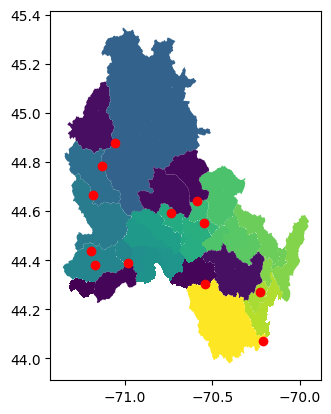

In [98]:
index = [i for i in G.nodes]
data = [d for _, d in G.nodes.data()]

gdf = gpd.GeoDataFrame(data).set_geometry("polygon")

ax = gdf.plot("uparea_km2")
gauges.plot(ax=ax, color="red")

In [99]:
gdf

,polygon,river_geom,area_km2,length_km,node_type,is_gauge,original_comid,nextdown,shreve_order,strahler_order,uparea_km2,lat,lng,snapped_lat,snapped_lng,is_outlet
0,"POLYGON ((-71.12625 44.44542, -71.12625 44.444...","LINESTRING (-71.0075 44.39333333333333, -71.00...",313.885303,18.206948,merged,False,73001332,73001331,2,2,3886.868911,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((-70.96125 44.44792, -70.96042 44.447...",LINESTRING (-70.97916666666666 44.395833333333...,58.471382,5.960689,merged,False,73001331,73001330,2,2,3945.340293,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((-70.98208 44.39125, -70.98292 44.391...",LINESTRING (-70.87666666666667 44.401666666666...,65.518246,9.901541,merged,False,73001330,73001329,3,2,4191.233793,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((-70.88792 44.40208, -70.88792 44.401...","LINESTRING (-70.78666666666666 44.415, -70.787...",134.476045,9.471395,merged,False,73001329,73001328,3,2,4325.709839,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((-70.70458 44.34875, -70.70542 44.348...","LINESTRING (-70.8 44.455, -70.8 44.45416666666...",93.089593,10.399041,merged,False,73001328,73001327,3,2,4418.799432,NaN,NaN,NaN,NaN,NaN
5,"POLYGON ((-70.78625 44.48625, -70.78625 44.485...","LINESTRING (-70.785 44.48583333333333, -70.785...",146.057710,14.879608,merged,False,73001327,73000857,3,2,4564.857142,NaN,NaN,NaN,NaN,NaN
6,"POLYGON ((-70.75292 44.53792, -70.75292 44.537...","LINESTRING (-70.67583333333333 44.505, -70.676...",187.114857,17.613147,merged,False,73000857,73001324,3,2,4751.971999,NaN,NaN,NaN,NaN,NaN
7,"POLYGON ((-70.64708 44.47792, -70.64625 44.477...","LINESTRING (-70.6175 44.51083333333334, -70.61...",87.997374,5.346074,merged,False,73000826,73000824,4,2,5266.771180,NaN,NaN,NaN,NaN,NaN
8,"POLYGON ((-70.31292 44.45958, -70.31292 44.458...","LINESTRING (-70.25 44.5125, -70.25083333333333...",95.018840,10.412513,merged,False,73000817,73001303,5,2,6337.346041,NaN,NaN,NaN,NaN,NaN
9,"POLYGON ((-70.15625 44.38042, -70.15625 44.379...",LINESTRING (-70.16416666666666 44.366666666666...,31.752951,4.105670,merged,False,73001302,73001301,5,2,6579.265282,NaN,NaN,NaN,NaN,NaN


<Axes: >

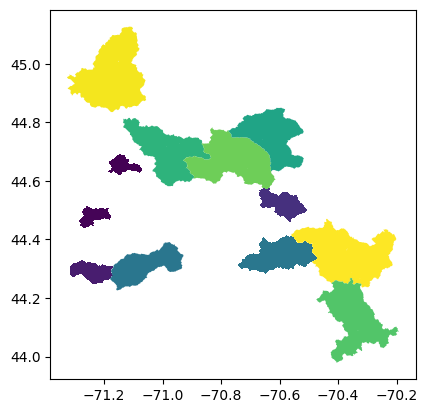

In [84]:
gdf[gdf["is_gauge"]].plot("area_km2")